## Date: 19 MARCH 2021 at 1:10 PM
## 10 sec segmented RESP BELT data

In [5]:
#============================
# Import important libraries
#============================
import pandas as pd 
import numpy as np
import scipy
import pywt
from creme import metrics
import time
import datetime
import math

from statistics import mode
from scipy import stats
from sklearn import preprocessing

from collections import defaultdict, Counter
from scipy.special import expit

from ANN_cls import *
from window_slider import Slider


from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

In [6]:
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values)> 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):    
    list_values = list_values[0,:]
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics

In [7]:
#======================================================
# RESP BELT Feature Extraction (Wavelet Features)
#======================================================

def extract_resp_belt_features(raw_data):
    features =[]
    resp_belt = raw_data
    list_coeff = pywt.wavedec(resp_belt, 'db4', level=3)
    
#     print(list_coeff)
    for coeff in list_coeff:
        features += get_features(coeff)
    return features

In [8]:
##===================================================
# Resp data read from files
##===================================================
def resp_data(p,v):
    file_resp = '/home/gp/Desktop/MER_arin/data/resp_data/'+str(p)+'_Respiration_data_from_DEAP.csv'
    print(file_resp)
    df = pd.read_csv(file_resp,sep=',', header = None, engine='python')
    resp_sig = df.loc[df.iloc[:,1] == v]
    return resp_sig

In [11]:
#=======================================
# MAIN PROGRAM STARTS HERE
#=======================================

segment_in_sec = 10 #in sec
bucket_size = int((8064/60)*segment_in_sec)  #8064 is for 60 sec record
print(bucket_size)
overlap_count = 0

l_max =0.9999
lr_min = 0.0001
eta_init = 1
b =1 

eta = 0.05

n_epoch =1
epochs =  1 #epoch is 1 because the model will be trained only once
optimizer= 'sgd' #optimizer
classifier = 'mlp-'+str(optimizer)
c = 0
run = 1

participant = 32
videos = 40

global eeg_emotion, eda_emotion, resp_emotion, mer_emotion, all_eta
eeg_emotion = []
eda_emotion = []
resp_emotion = []
mer_emotion = []

all_eta =[]
init_m = 0

#================================================
# Performance matric declaration here
#================================================

resp_acc_val = metrics.Accuracy() #Accuracy
resp_f1m_val = metrics.F1() #F1 measure  
resp_acc_aro = metrics.Accuracy() #Accuracy
resp_f1m_aro = metrics.F1() #F1 measure
    
itr = 0 #controls the learning rate


for ii in range(0,participant):


        # if(ii >2):
        # 	break

        p =ii+1
        for jj in range(0,videos):
            v = jj+1
            p_v = 'Person:'+ ' ' +str(p)+ ' ' +'Video:'+str(v)
            
        
            ##===================================================
            # RESP BELT data read from files
            ##===================================================
            resp_sig = resp_data(p,v)
            
            #=================================================
            #emotion labels (valence, arousal) mapping 0-1
            #=================================================
            val = resp_sig.iloc[0,8067]
            aro = resp_sig.iloc[0,8068]
            
#             print('val:{}, arousal:{}'.format(val,aro))

            #valence emotion maping 0-> low valence and 1-> high valence

            if (val >5):
                vl = 1 #high valence
            else:
                vl = 0 #low valence

            #arousal emotion maping 0-> low arousal and 1-> high high arousal
            if (aro >5):
                al = 1 #high arousal
            else:
                al = 0 #low arousal
                
            y_act_val = vl
            y_act_aro = al  
            
            #=========================================
            # Sliding window starts here 
            #=========================================
            slider = Slider(bucket_size,overlap_count)
            resp_sig = np.array(resp_sig.iloc[:,range(3,8067)]) #keeping only eeg signals
            
            print(resp_sig.shape)
            slider.fit(resp_sig)   

            while True:
                window_data = slider.slide()
                #=================================================
                # Feature extraction from Resp belt
                #=================================================

                resp_features = extract_resp_belt_features(np.array(window_data))
                resp = np.array([resp_features]) #RESP BELT raw feature vector
                x_resp = preprocessing.normalize(resp) #RESP BELT normalized features
            
                #===================================================
                # Model initialization
                #===================================================
                if init_m == 0:
                    resp_size_hidden = math.ceil(x_resp.shape[1]*(2/3))

                    #========================
                    # For EDA data MLp model
                    #========================
                    resp_model_val = ANN()
                    resp_model_val.add(layers.layer(x_resp.shape[1], 'sigmoid'))
                    resp_model_val.add(layers.layer(resp_size_hidden, 'sigmoid'))
                    resp_model_val.add(layers.layer(1, 'sigmoid'))

                    resp_model_aro = ANN()
                    resp_model_aro.add(layers.layer(x_resp.shape[1], 'sigmoid'))
                    resp_model_aro.add(layers.layer(resp_size_hidden, 'sigmoid'))
                    resp_model_aro.add(layers.layer(1, 'sigmoid'))


                    init_m = init_m+1


                #===============================================================
                # Emotion Classification --> Valence and Arousal
                #===============================================================

                #===========================================
                # From Resp Belt data
                #===========================================

                #Valence classification Resp Belt

                #Test the model first 
                y_pred_val_resp = resp_model_val.predict_once(x_resp,c)

                #Train the model once
                resp_model_val.fit_once(x_resp,y_act_val, eta,c)

                resp_acc_val = resp_acc_val.update(y_act_val, y_pred_val_resp)  # update the accuracy metric

                resp_f1m_val = resp_f1m_val.update(y_act_val, y_pred_val_resp) #update f1 measure metric

                #Arousal classification Resp Belt
                #Test the model first 
                y_pred_aro_resp = resp_model_aro.predict_once(x_resp,c)

                #Train the model once
                resp_model_aro.fit_once(x_resp,y_act_aro, eta,c)

                resp_acc_aro = resp_acc_aro.update(y_act_aro, y_pred_aro_resp)  # update the accuracy metric

                resp_f1m_aro = resp_f1m_aro.update(y_act_aro, y_pred_aro_resp) #update f1 measure metric

                if slider.reached_end_of_list(): break
                
                c = c+1
        
            
            
            
            resp_emotion.append(np.array([p,v, resp_acc_val.get(), resp_f1m_val.get(), resp_acc_aro.get(), resp_f1m_aro.get(), y_act_val, y_pred_val_resp, y_act_aro, y_pred_aro_resp]))
            print('===============================================================')
            print(p_v)
            print('Actual emotion [valence: {}, arousal: {}]'.format(y_act_val, y_act_aro))
            print('Predicted emotion [valence: {}, arousal: {}]'.format(y_pred_val_resp, y_pred_aro_resp))
            
            print('..................................................')
            print('EDA')

            print("Valence Accuracy:{}".format(round(resp_acc_val.get(),4)))
            print("Valence F1 score:{}".format(round(resp_f1m_val.get(),4)))
            print("Arousal Accuracy:{}".format(round(resp_acc_val.get(),4)))
            print("Arousal F1 score:{}".format(round(resp_f1m_val.get(),4)))
                
                
            


1344
/home/gp/Desktop/MER_arin/data/resp_data/1_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 1 Video:1
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.6667
Valence F1 score:0.8
Arousal Accuracy:0.6667
Arousal F1 score:0.8
/home/gp/Desktop/MER_arin/data/resp_data/1_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 1 Video:2
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8333
Valence F1 score:0.9091
Arousal Accuracy:0.8333
Arousal F1 score:0.9091
/home/gp/Desktop/MER_arin/data/resp_data/1_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 1 Video:3
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8889
Valence F1 score:0.9412
Arousal Accuracy:0.8889

(1, 8064)
Person: 1 Video:21
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8889
Valence F1 score:0.9
Arousal Accuracy:0.8889
Arousal F1 score:0.9
/home/gp/Desktop/MER_arin/data/resp_data/1_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 1 Video:22
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8939
Valence F1 score:0.9079
Arousal Accuracy:0.8939
Arousal F1 score:0.9079
/home/gp/Desktop/MER_arin/data/resp_data/1_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 1 Video:23
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8986
Valence F1 score:0.9146
Arousal Accuracy:0.8986
Arousal F1 score:0.9146
/home/gp/Desktop/MER_arin/data/resp_data/1_Respirat

(1, 8064)
Person: 2 Video:2
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9206
Valence F1 score:0.9187
Arousal Accuracy:0.9206
Arousal F1 score:0.9187
/home/gp/Desktop/MER_arin/data/resp_data/2_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 2 Video:3
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9225
Valence F1 score:0.9225
Arousal Accuracy:0.9225
Arousal F1 score:0.9225
/home/gp/Desktop/MER_arin/data/resp_data/2_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 2 Video:4
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9242
Valence F1 score:0.9259
Arousal Accuracy:0.9242
Arousal F1 score:0.9259
/home/gp/Desktop/MER_arin/data/resp_data/2_Respi

(1, 8064)
Person: 2 Video:23
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9233
Valence F1 score:0.9321
Arousal Accuracy:0.9233
Arousal F1 score:0.9321
/home/gp/Desktop/MER_arin/data/resp_data/2_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 2 Video:24
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9193
Valence F1 score:0.9291
Arousal Accuracy:0.9193
Arousal F1 score:0.9291
/home/gp/Desktop/MER_arin/data/resp_data/2_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 2 Video:25
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9205
Valence F1 score:0.931
Arousal Accuracy:0.9205
Arousal F1 score:0.931
/home/gp/Desktop/MER_arin/data/resp_data/2_Resp

(1, 8064)
Person: 3 Video:4
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9187
Valence F1 score:0.9213
Arousal Accuracy:0.9187
Arousal F1 score:0.9213
/home/gp/Desktop/MER_arin/data/resp_data/3_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 3 Video:5
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9157
Valence F1 score:0.919
Arousal Accuracy:0.9157
Arousal F1 score:0.919
/home/gp/Desktop/MER_arin/data/resp_data/3_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 3 Video:6
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9167
Valence F1 score:0.9208
Arousal Accuracy:0.9167
Arousal F1 score:0.9208
/home/gp/Desktop/MER_arin/data/resp_data/3_Respira

(1, 8064)
Person: 3 Video:25
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9159
Valence F1 score:0.9231
Arousal Accuracy:0.9159
Arousal F1 score:0.9231
/home/gp/Desktop/MER_arin/data/resp_data/3_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 3 Video:26
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9167
Valence F1 score:0.9231
Arousal Accuracy:0.9167
Arousal F1 score:0.9231
/home/gp/Desktop/MER_arin/data/resp_data/3_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 3 Video:27
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9128
Valence F1 score:0.9198
Arousal Accuracy:0.9128
Arousal F1 score:0.9198
/home/gp/Desktop/MER_arin/data/resp_data/3_Re

(1, 8064)
Person: 4 Video:6
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9021
Valence F1 score:0.9059
Arousal Accuracy:0.9021
Arousal F1 score:0.9059
/home/gp/Desktop/MER_arin/data/resp_data/4_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 4 Video:7
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9016
Valence F1 score:0.9047
Arousal Accuracy:0.9016
Arousal F1 score:0.9047
/home/gp/Desktop/MER_arin/data/resp_data/4_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 4 Video:8
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8997
Valence F1 score:0.9034
Arousal Accuracy:0.8997
Arousal F1 score:0.9034
/home/gp/Desktop/MER_arin/data/resp_data/4_Respi

(1, 8064)
Person: 4 Video:27
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8946
Valence F1 score:0.8995
Arousal Accuracy:0.8946
Arousal F1 score:0.8995
/home/gp/Desktop/MER_arin/data/resp_data/4_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 4 Video:28
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.893
Valence F1 score:0.8975
Arousal Accuracy:0.893
Arousal F1 score:0.8975
/home/gp/Desktop/MER_arin/data/resp_data/4_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 4 Video:29
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8937
Valence F1 score:0.8975
Arousal Accuracy:0.8937
Arousal F1 score:0.8975
/home/gp/Desktop/MER_arin/data/resp_data/4_Resp

(1, 8064)
Person: 5 Video:8
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8958
Valence F1 score:0.8945
Arousal Accuracy:0.8958
Arousal F1 score:0.8945
/home/gp/Desktop/MER_arin/data/resp_data/5_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 5 Video:9
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8964
Valence F1 score:0.8957
Arousal Accuracy:0.8964
Arousal F1 score:0.8957
/home/gp/Desktop/MER_arin/data/resp_data/5_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 5 Video:10
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8951
Valence F1 score:0.894
Arousal Accuracy:0.8951
Arousal F1 score:0.894
/home/gp/Desktop/MER_arin/data/resp_data/5_Respir

(1, 8064)
Person: 5 Video:29
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8924
Valence F1 score:0.8952
Arousal Accuracy:0.8924
Arousal F1 score:0.8952
/home/gp/Desktop/MER_arin/data/resp_data/5_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 5 Video:30
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.893
Valence F1 score:0.8952
Arousal Accuracy:0.893
Arousal F1 score:0.8952
/home/gp/Desktop/MER_arin/data/resp_data/5_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 5 Video:31
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8918
Valence F1 score:0.8944
Arousal Accuracy:0.8918
Arousal F1 score:0.8944
/home/gp/Desktop/MER_arin/data/resp_data/5_Resp

(1, 8064)
Person: 6 Video:10
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8952
Valence F1 score:0.9006
Arousal Accuracy:0.8952
Arousal F1 score:0.9006
/home/gp/Desktop/MER_arin/data/resp_data/6_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 6 Video:11
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8942
Valence F1 score:0.8992
Arousal Accuracy:0.8942
Arousal F1 score:0.8992
/home/gp/Desktop/MER_arin/data/resp_data/6_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 6 Video:12
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8931
Valence F1 score:0.8985
Arousal Accuracy:0.8931
Arousal F1 score:0.8985
/home/gp/Desktop/MER_arin/data/resp_data/6_Re

(1, 8064)
Person: 6 Video:31
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8961
Valence F1 score:0.9054
Arousal Accuracy:0.8961
Arousal F1 score:0.9054
/home/gp/Desktop/MER_arin/data/resp_data/6_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 6 Video:32
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8951
Valence F1 score:0.9047
Arousal Accuracy:0.8951
Arousal F1 score:0.9047
/home/gp/Desktop/MER_arin/data/resp_data/6_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 6 Video:33
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8956
Valence F1 score:0.9054
Arousal Accuracy:0.8956
Arousal F1 score:0.9054
/home/gp/Desktop/MER_arin/data/resp_data/6_Re

(1, 8064)
Person: 7 Video:12
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8968
Valence F1 score:0.9088
Arousal Accuracy:0.8968
Arousal F1 score:0.9088
/home/gp/Desktop/MER_arin/data/resp_data/7_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 7 Video:13
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8972
Valence F1 score:0.9094
Arousal Accuracy:0.8972
Arousal F1 score:0.9094
/home/gp/Desktop/MER_arin/data/resp_data/7_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 7 Video:14
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8976
Valence F1 score:0.91
Arousal Accuracy:0.8976
Arousal F1 score:0.91
/home/gp/Desktop/MER_arin/data/resp_data/7_Respir

(1, 8064)
Person: 7 Video:33
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8962
Valence F1 score:0.9071
Arousal Accuracy:0.8962
Arousal F1 score:0.9071
/home/gp/Desktop/MER_arin/data/resp_data/7_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 7 Video:34
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8966
Valence F1 score:0.9071
Arousal Accuracy:0.8966
Arousal F1 score:0.9071
/home/gp/Desktop/MER_arin/data/resp_data/7_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 7 Video:35
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8958
Valence F1 score:0.9065
Arousal Accuracy:0.8958
Arousal F1 score:0.9065
/home/gp/Desktop/MER_arin/data/resp_data/7_Re

(1, 8064)
Person: 8 Video:14
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8985
Valence F1 score:0.9125
Arousal Accuracy:0.8985
Arousal F1 score:0.9125
/home/gp/Desktop/MER_arin/data/resp_data/8_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 8 Video:15
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8989
Valence F1 score:0.913
Arousal Accuracy:0.8989
Arousal F1 score:0.913
/home/gp/Desktop/MER_arin/data/resp_data/8_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 8 Video:16
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8981
Valence F1 score:0.9121
Arousal Accuracy:0.8981
Arousal F1 score:0.9121
/home/gp/Desktop/MER_arin/data/resp_data/8_Resp

(1, 8064)
Person: 8 Video:35
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8968
Valence F1 score:0.9089
Arousal Accuracy:0.8968
Arousal F1 score:0.9089
/home/gp/Desktop/MER_arin/data/resp_data/8_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 8 Video:36
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8972
Valence F1 score:0.9089
Arousal Accuracy:0.8972
Arousal F1 score:0.9089
/home/gp/Desktop/MER_arin/data/resp_data/8_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 8 Video:37
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8964
Valence F1 score:0.9084
Arousal Accuracy:0.8964
Arousal F1 score:0.9084
/home/gp/Desktop/MER_arin/data/resp_data/8_Re

(1, 8064)
Person: 9 Video:16
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8948
Valence F1 score:0.9087
Arousal Accuracy:0.8948
Arousal F1 score:0.9087
/home/gp/Desktop/MER_arin/data/resp_data/9_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 9 Video:17
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8947
Valence F1 score:0.9087
Arousal Accuracy:0.8947
Arousal F1 score:0.9087
/home/gp/Desktop/MER_arin/data/resp_data/9_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 9 Video:18
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8945
Valence F1 score:0.9083
Arousal Accuracy:0.8945
Arousal F1 score:0.9083
/home/gp/Desktop/MER_arin/data/resp_data/9_Re

(1, 8064)
Person: 9 Video:37
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8931
Valence F1 score:0.9042
Arousal Accuracy:0.8931
Arousal F1 score:0.9042
/home/gp/Desktop/MER_arin/data/resp_data/9_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 9 Video:38
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8934
Valence F1 score:0.9042
Arousal Accuracy:0.8934
Arousal F1 score:0.9042
/home/gp/Desktop/MER_arin/data/resp_data/9_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 9 Video:39
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8937
Valence F1 score:0.9042
Arousal Accuracy:0.8937
Arousal F1 score:0.9042
/home/gp/Desktop/MER_arin/data/resp_data/9_Re

(1, 8064)
Person: 10 Video:18
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8951
Valence F1 score:0.9078
Arousal Accuracy:0.8951
Arousal F1 score:0.9078
/home/gp/Desktop/MER_arin/data/resp_data/10_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 10 Video:19
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8953
Valence F1 score:0.9082
Arousal Accuracy:0.8953
Arousal F1 score:0.9082
/home/gp/Desktop/MER_arin/data/resp_data/10_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 10 Video:20
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8956
Valence F1 score:0.9087
Arousal Accuracy:0.8956
Arousal F1 score:0.9087
/home/gp/Desktop/MER_arin/data/resp_data

(1, 8064)
Person: 10 Video:39
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8964
Valence F1 score:0.9058
Arousal Accuracy:0.8964
Arousal F1 score:0.9058
/home/gp/Desktop/MER_arin/data/resp_data/10_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 10 Video:40
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8958
Valence F1 score:0.9054
Arousal Accuracy:0.8958
Arousal F1 score:0.9054
/home/gp/Desktop/MER_arin/data/resp_data/11_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 11 Video:1
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8961
Valence F1 score:0.9058
Arousal Accuracy:0.8961
Arousal F1 score:0.9058
/home/gp/Desktop/MER_arin/data/resp_data/

(1, 8064)
Person: 11 Video:20
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8996
Valence F1 score:0.9119
Arousal Accuracy:0.8996
Arousal F1 score:0.9119
/home/gp/Desktop/MER_arin/data/resp_data/11_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 11 Video:21
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.899
Valence F1 score:0.9112
Arousal Accuracy:0.899
Arousal F1 score:0.9112
/home/gp/Desktop/MER_arin/data/resp_data/11_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 11 Video:22
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8989
Valence F1 score:0.9112
Arousal Accuracy:0.8989
Arousal F1 score:0.9112
/home/gp/Desktop/MER_arin/data/resp_data/1

(1, 8064)
Person: 12 Video:1
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8991
Valence F1 score:0.9093
Arousal Accuracy:0.8991
Arousal F1 score:0.9093
/home/gp/Desktop/MER_arin/data/resp_data/12_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 12 Video:2
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8993
Valence F1 score:0.9096
Arousal Accuracy:0.8993
Arousal F1 score:0.9096
/home/gp/Desktop/MER_arin/data/resp_data/12_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 12 Video:3
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8995
Valence F1 score:0.91
Arousal Accuracy:0.8995
Arousal F1 score:0.91
/home/gp/Desktop/MER_arin/data/resp_data/12_Res

(1, 8064)
Person: 12 Video:22
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8997
Valence F1 score:0.9115
Arousal Accuracy:0.8997
Arousal F1 score:0.9115
/home/gp/Desktop/MER_arin/data/resp_data/12_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 12 Video:23
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8999
Valence F1 score:0.9115
Arousal Accuracy:0.8999
Arousal F1 score:0.9115
/home/gp/Desktop/MER_arin/data/resp_data/12_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 12 Video:24
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9001
Valence F1 score:0.9115
Arousal Accuracy:0.9001
Arousal F1 score:0.9115
/home/gp/Desktop/MER_arin/data/resp_data

(1, 8064)
Person: 13 Video:3
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.901
Valence F1 score:0.9106
Arousal Accuracy:0.901
Arousal F1 score:0.9106
/home/gp/Desktop/MER_arin/data/resp_data/13_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 13 Video:4
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9012
Valence F1 score:0.911
Arousal Accuracy:0.9012
Arousal F1 score:0.911
/home/gp/Desktop/MER_arin/data/resp_data/13_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 13 Video:5
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9014
Valence F1 score:0.9113
Arousal Accuracy:0.9014
Arousal F1 score:0.9113
/home/gp/Desktop/MER_arin/data/resp_data/13_Res

(1, 8064)
Person: 13 Video:24
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9015
Valence F1 score:0.9113
Arousal Accuracy:0.9015
Arousal F1 score:0.9113
/home/gp/Desktop/MER_arin/data/resp_data/13_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 13 Video:25
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9017
Valence F1 score:0.9113
Arousal Accuracy:0.9017
Arousal F1 score:0.9113
/home/gp/Desktop/MER_arin/data/resp_data/13_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 13 Video:26
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9012
Valence F1 score:0.911
Arousal Accuracy:0.9012
Arousal F1 score:0.911
/home/gp/Desktop/MER_arin/data/resp_data/1

(1, 8064)
Person: 14 Video:5
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9029
Valence F1 score:0.9111
Arousal Accuracy:0.9029
Arousal F1 score:0.9111
/home/gp/Desktop/MER_arin/data/resp_data/14_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 14 Video:6
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9027
Valence F1 score:0.9111
Arousal Accuracy:0.9027
Arousal F1 score:0.9111
/home/gp/Desktop/MER_arin/data/resp_data/14_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 14 Video:7
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9029
Valence F1 score:0.9115
Arousal Accuracy:0.9029
Arousal F1 score:0.9115
/home/gp/Desktop/MER_arin/data/resp_data/14

(1, 8064)
Person: 14 Video:26
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9029
Valence F1 score:0.9118
Arousal Accuracy:0.9029
Arousal F1 score:0.9118
/home/gp/Desktop/MER_arin/data/resp_data/14_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 14 Video:27
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9028
Valence F1 score:0.9118
Arousal Accuracy:0.9028
Arousal F1 score:0.9118
/home/gp/Desktop/MER_arin/data/resp_data/14_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 14 Video:28
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9027
Valence F1 score:0.9115
Arousal Accuracy:0.9027
Arousal F1 score:0.9115
/home/gp/Desktop/MER_arin/data/resp_data

(1, 8064)
Person: 15 Video:7
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9053
Valence F1 score:0.9135
Arousal Accuracy:0.9053
Arousal F1 score:0.9135
/home/gp/Desktop/MER_arin/data/resp_data/15_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 15 Video:8
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9055
Valence F1 score:0.9138
Arousal Accuracy:0.9055
Arousal F1 score:0.9138
/home/gp/Desktop/MER_arin/data/resp_data/15_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 15 Video:9
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9057
Valence F1 score:0.914
Arousal Accuracy:0.9057
Arousal F1 score:0.914
/home/gp/Desktop/MER_arin/data/resp_data/15_R

(1, 8064)
Person: 15 Video:28
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9039
Valence F1 score:0.9125
Arousal Accuracy:0.9039
Arousal F1 score:0.9125
/home/gp/Desktop/MER_arin/data/resp_data/15_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 15 Video:29
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9041
Valence F1 score:0.9125
Arousal Accuracy:0.9041
Arousal F1 score:0.9125
/home/gp/Desktop/MER_arin/data/resp_data/15_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 15 Video:30
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9042
Valence F1 score:0.9125
Arousal Accuracy:0.9042
Arousal F1 score:0.9125
/home/gp/Desktop/MER_arin/data/resp_data

(1, 8064)
Person: 16 Video:9
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9037
Valence F1 score:0.9108
Arousal Accuracy:0.9037
Arousal F1 score:0.9108
/home/gp/Desktop/MER_arin/data/resp_data/16_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 16 Video:10
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9033
Valence F1 score:0.9106
Arousal Accuracy:0.9033
Arousal F1 score:0.9106
/home/gp/Desktop/MER_arin/data/resp_data/16_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 16 Video:11
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9034
Valence F1 score:0.9108
Arousal Accuracy:0.9034
Arousal F1 score:0.9108
/home/gp/Desktop/MER_arin/data/resp_data/

(1, 8064)
Person: 16 Video:30
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9029
Valence F1 score:0.9087
Arousal Accuracy:0.9029
Arousal F1 score:0.9087
/home/gp/Desktop/MER_arin/data/resp_data/16_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 16 Video:31
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9025
Valence F1 score:0.9082
Arousal Accuracy:0.9025
Arousal F1 score:0.9082
/home/gp/Desktop/MER_arin/data/resp_data/16_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 16 Video:32
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9024
Valence F1 score:0.9082
Arousal Accuracy:0.9024
Arousal F1 score:0.9082
/home/gp/Desktop/MER_arin/data/resp_data

(1, 8064)
Person: 17 Video:11
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9022
Valence F1 score:0.9088
Arousal Accuracy:0.9022
Arousal F1 score:0.9088
/home/gp/Desktop/MER_arin/data/resp_data/17_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 17 Video:12
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9024
Valence F1 score:0.9091
Arousal Accuracy:0.9024
Arousal F1 score:0.9091
/home/gp/Desktop/MER_arin/data/resp_data/17_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 17 Video:13
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9015
Valence F1 score:0.9082
Arousal Accuracy:0.9015
Arousal F1 score:0.9082
/home/gp/Desktop/MER_arin/data/resp_data

(1, 8064)
Person: 17 Video:32
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9
Valence F1 score:0.9067
Arousal Accuracy:0.9
Arousal F1 score:0.9067
/home/gp/Desktop/MER_arin/data/resp_data/17_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 17 Video:33
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9002
Valence F1 score:0.9067
Arousal Accuracy:0.9002
Arousal F1 score:0.9067
/home/gp/Desktop/MER_arin/data/resp_data/17_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 17 Video:34
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9003
Valence F1 score:0.9067
Arousal Accuracy:0.9003
Arousal F1 score:0.9067
/home/gp/Desktop/MER_arin/data/resp_data/17_Re

(1, 8064)
Person: 18 Video:13
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9014
Valence F1 score:0.9086
Arousal Accuracy:0.9014
Arousal F1 score:0.9086
/home/gp/Desktop/MER_arin/data/resp_data/18_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 18 Video:14
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9015
Valence F1 score:0.9089
Arousal Accuracy:0.9015
Arousal F1 score:0.9089
/home/gp/Desktop/MER_arin/data/resp_data/18_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 18 Video:15
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9017
Valence F1 score:0.9091
Arousal Accuracy:0.9017
Arousal F1 score:0.9091
/home/gp/Desktop/MER_arin/data/resp_data

(1, 8064)
Person: 18 Video:34
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9001
Valence F1 score:0.9073
Arousal Accuracy:0.9001
Arousal F1 score:0.9073
/home/gp/Desktop/MER_arin/data/resp_data/18_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 18 Video:35
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8998
Valence F1 score:0.9071
Arousal Accuracy:0.8998
Arousal F1 score:0.9071
/home/gp/Desktop/MER_arin/data/resp_data/18_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 18 Video:36
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8999
Valence F1 score:0.9073
Arousal Accuracy:0.8999
Arousal F1 score:0.9073
/home/gp/Desktop/MER_arin/data/resp_data

(1, 8064)
Person: 19 Video:15
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9014
Valence F1 score:0.9098
Arousal Accuracy:0.9014
Arousal F1 score:0.9098
/home/gp/Desktop/MER_arin/data/resp_data/19_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 19 Video:16
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9001
Valence F1 score:0.9086
Arousal Accuracy:0.9001
Arousal F1 score:0.9086
/home/gp/Desktop/MER_arin/data/resp_data/19_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 19 Video:17
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.9
Valence F1 score:0.9086
Arousal Accuracy:0.9
Arousal F1 score:0.9086
/home/gp/Desktop/MER_arin/data/resp_data/19_Re

(1, 8064)
Person: 19 Video:36
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8986
Valence F1 score:0.9065
Arousal Accuracy:0.8986
Arousal F1 score:0.9065
/home/gp/Desktop/MER_arin/data/resp_data/19_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 19 Video:37
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8987
Valence F1 score:0.9065
Arousal Accuracy:0.8987
Arousal F1 score:0.9065
/home/gp/Desktop/MER_arin/data/resp_data/19_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 19 Video:38
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8989
Valence F1 score:0.9065
Arousal Accuracy:0.8989
Arousal F1 score:0.9065
/home/gp/Desktop/MER_arin/data/resp_data

(1, 8064)
Person: 20 Video:17
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8998
Valence F1 score:0.909
Arousal Accuracy:0.8998
Arousal F1 score:0.909
/home/gp/Desktop/MER_arin/data/resp_data/20_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 20 Video:18
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9
Valence F1 score:0.9092
Arousal Accuracy:0.9
Arousal F1 score:0.9092
/home/gp/Desktop/MER_arin/data/resp_data/20_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 20 Video:19
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.9001
Valence F1 score:0.9094
Arousal Accuracy:0.9001
Arousal F1 score:0.9094
/home/gp/Desktop/MER_arin/data/resp_data/20_Resp

(1, 8064)
Person: 20 Video:38
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8989
Valence F1 score:0.9071
Arousal Accuracy:0.8989
Arousal F1 score:0.9071
/home/gp/Desktop/MER_arin/data/resp_data/20_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 20 Video:39
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.899
Valence F1 score:0.9071
Arousal Accuracy:0.899
Arousal F1 score:0.9071
/home/gp/Desktop/MER_arin/data/resp_data/20_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 20 Video:40
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8992
Valence F1 score:0.9071
Arousal Accuracy:0.8992
Arousal F1 score:0.9071
/home/gp/Desktop/MER_arin/data/resp_data/2

(1, 8064)
Person: 21 Video:19
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.898
Valence F1 score:0.9073
Arousal Accuracy:0.898
Arousal F1 score:0.9073
/home/gp/Desktop/MER_arin/data/resp_data/21_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 21 Video:20
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8972
Valence F1 score:0.9065
Arousal Accuracy:0.8972
Arousal F1 score:0.9065
/home/gp/Desktop/MER_arin/data/resp_data/21_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 21 Video:21
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8973
Valence F1 score:0.9065
Arousal Accuracy:0.8973
Arousal F1 score:0.9065
/home/gp/Desktop/MER_arin/data/resp_data/2

(1, 8064)
Person: 21 Video:40
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.896
Valence F1 score:0.9043
Arousal Accuracy:0.896
Arousal F1 score:0.9043
/home/gp/Desktop/MER_arin/data/resp_data/22_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 22 Video:1
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8958
Valence F1 score:0.9041
Arousal Accuracy:0.8958
Arousal F1 score:0.9041
/home/gp/Desktop/MER_arin/data/resp_data/22_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 22 Video:2
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8959
Valence F1 score:0.9043
Arousal Accuracy:0.8959
Arousal F1 score:0.9043
/home/gp/Desktop/MER_arin/data/resp_data/22_

(1, 8064)
Person: 22 Video:21
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8926
Valence F1 score:0.9023
Arousal Accuracy:0.8926
Arousal F1 score:0.9023
/home/gp/Desktop/MER_arin/data/resp_data/22_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 22 Video:22
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8927
Valence F1 score:0.9023
Arousal Accuracy:0.8927
Arousal F1 score:0.9023
/home/gp/Desktop/MER_arin/data/resp_data/22_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 22 Video:23
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8928
Valence F1 score:0.9023
Arousal Accuracy:0.8928
Arousal F1 score:0.9023
/home/gp/Desktop/MER_arin/data/resp_data

(1, 8064)
Person: 23 Video:2
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8923
Valence F1 score:0.9005
Arousal Accuracy:0.8923
Arousal F1 score:0.9005
/home/gp/Desktop/MER_arin/data/resp_data/23_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 23 Video:3
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8924
Valence F1 score:0.9007
Arousal Accuracy:0.8924
Arousal F1 score:0.9007
/home/gp/Desktop/MER_arin/data/resp_data/23_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 23 Video:4
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8925
Valence F1 score:0.9009
Arousal Accuracy:0.8925
Arousal F1 score:0.9009
/home/gp/Desktop/MER_arin/data/resp_data/23

(1, 8064)
Person: 23 Video:23
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8928
Valence F1 score:0.902
Arousal Accuracy:0.8928
Arousal F1 score:0.902
/home/gp/Desktop/MER_arin/data/resp_data/23_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 23 Video:24
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8923
Valence F1 score:0.9017
Arousal Accuracy:0.8923
Arousal F1 score:0.9017
/home/gp/Desktop/MER_arin/data/resp_data/23_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 23 Video:25
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8919
Valence F1 score:0.9012
Arousal Accuracy:0.8919
Arousal F1 score:0.9012
/home/gp/Desktop/MER_arin/data/resp_data/2

(1, 8064)
Person: 24 Video:4
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8905
Valence F1 score:0.9001
Arousal Accuracy:0.8905
Arousal F1 score:0.9001
/home/gp/Desktop/MER_arin/data/resp_data/24_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 24 Video:5
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8906
Valence F1 score:0.9003
Arousal Accuracy:0.8906
Arousal F1 score:0.9003
/home/gp/Desktop/MER_arin/data/resp_data/24_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 24 Video:6
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8907
Valence F1 score:0.9005
Arousal Accuracy:0.8907
Arousal F1 score:0.9005
/home/gp/Desktop/MER_arin/data/resp_data/24

(1, 8064)
Person: 24 Video:25
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8898
Valence F1 score:0.8997
Arousal Accuracy:0.8898
Arousal F1 score:0.8997
/home/gp/Desktop/MER_arin/data/resp_data/24_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 24 Video:26
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8899
Valence F1 score:0.8997
Arousal Accuracy:0.8899
Arousal F1 score:0.8997
/home/gp/Desktop/MER_arin/data/resp_data/24_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 24 Video:27
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8893
Valence F1 score:0.8992
Arousal Accuracy:0.8893
Arousal F1 score:0.8992
/home/gp/Desktop/MER_arin/data/resp_data

(1, 8064)
Person: 25 Video:6
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8877
Valence F1 score:0.8966
Arousal Accuracy:0.8877
Arousal F1 score:0.8966
/home/gp/Desktop/MER_arin/data/resp_data/25_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 25 Video:7
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8875
Valence F1 score:0.8964
Arousal Accuracy:0.8875
Arousal F1 score:0.8964
/home/gp/Desktop/MER_arin/data/resp_data/25_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 25 Video:8
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8874
Valence F1 score:0.8964
Arousal Accuracy:0.8874
Arousal F1 score:0.8964
/home/gp/Desktop/MER_arin/data/resp_data/25

(1, 8064)
Person: 25 Video:27
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8842
Valence F1 score:0.8941
Arousal Accuracy:0.8842
Arousal F1 score:0.8941
/home/gp/Desktop/MER_arin/data/resp_data/25_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 25 Video:28
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8841
Valence F1 score:0.8941
Arousal Accuracy:0.8841
Arousal F1 score:0.8941
/home/gp/Desktop/MER_arin/data/resp_data/25_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 25 Video:29
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8841
Valence F1 score:0.894
Arousal Accuracy:0.8841
Arousal F1 score:0.894
/home/gp/Desktop/MER_arin/data/resp_data/2

(1, 8064)
Person: 26 Video:8
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8816
Valence F1 score:0.891
Arousal Accuracy:0.8816
Arousal F1 score:0.891
/home/gp/Desktop/MER_arin/data/resp_data/26_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 26 Video:9
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8817
Valence F1 score:0.8912
Arousal Accuracy:0.8817
Arousal F1 score:0.8912
/home/gp/Desktop/MER_arin/data/resp_data/26_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 26 Video:10
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.881
Valence F1 score:0.8905
Arousal Accuracy:0.881
Arousal F1 score:0.8905
/home/gp/Desktop/MER_arin/data/resp_data/26_Re

(1, 8064)
Person: 26 Video:29
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8822
Valence F1 score:0.8932
Arousal Accuracy:0.8822
Arousal F1 score:0.8932
/home/gp/Desktop/MER_arin/data/resp_data/26_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 26 Video:30
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8817
Valence F1 score:0.8927
Arousal Accuracy:0.8817
Arousal F1 score:0.8927
/home/gp/Desktop/MER_arin/data/resp_data/26_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 26 Video:31
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8815
Valence F1 score:0.8924
Arousal Accuracy:0.8815
Arousal F1 score:0.8924
/home/gp/Desktop/MER_arin/data/resp_data

(1, 8064)
Person: 27 Video:10
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8805
Valence F1 score:0.891
Arousal Accuracy:0.8805
Arousal F1 score:0.891
/home/gp/Desktop/MER_arin/data/resp_data/27_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 27 Video:11
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8806
Valence F1 score:0.8912
Arousal Accuracy:0.8806
Arousal F1 score:0.8912
/home/gp/Desktop/MER_arin/data/resp_data/27_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 27 Video:12
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8798
Valence F1 score:0.8905
Arousal Accuracy:0.8798
Arousal F1 score:0.8905
/home/gp/Desktop/MER_arin/data/resp_data/2

(1, 8064)
Person: 27 Video:31
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8796
Valence F1 score:0.8916
Arousal Accuracy:0.8796
Arousal F1 score:0.8916
/home/gp/Desktop/MER_arin/data/resp_data/27_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 27 Video:32
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8797
Valence F1 score:0.8918
Arousal Accuracy:0.8797
Arousal F1 score:0.8918
/home/gp/Desktop/MER_arin/data/resp_data/27_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 27 Video:33
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8798
Valence F1 score:0.892
Arousal Accuracy:0.8798
Arousal F1 score:0.892
/home/gp/Desktop/MER_arin/data/resp_data/2

(1, 8064)
Person: 28 Video:12
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8785
Valence F1 score:0.8915
Arousal Accuracy:0.8785
Arousal F1 score:0.8915
/home/gp/Desktop/MER_arin/data/resp_data/28_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 28 Video:13
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8777
Valence F1 score:0.8908
Arousal Accuracy:0.8777
Arousal F1 score:0.8908
/home/gp/Desktop/MER_arin/data/resp_data/28_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 28 Video:14
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8775
Valence F1 score:0.8907
Arousal Accuracy:0.8775
Arousal F1 score:0.8907
/home/gp/Desktop/MER_arin/data/resp_data

(1, 8064)
Person: 28 Video:33
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8757
Valence F1 score:0.889
Arousal Accuracy:0.8757
Arousal F1 score:0.889
/home/gp/Desktop/MER_arin/data/resp_data/28_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 28 Video:34
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8758
Valence F1 score:0.8892
Arousal Accuracy:0.8758
Arousal F1 score:0.8892
/home/gp/Desktop/MER_arin/data/resp_data/28_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 28 Video:35
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.875
Valence F1 score:0.8884
Arousal Accuracy:0.875
Arousal F1 score:0.8884
/home/gp/Desktop/MER_arin/data/resp_data/28_

(1, 8064)
Person: 29 Video:14
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8751
Valence F1 score:0.8891
Arousal Accuracy:0.8751
Arousal F1 score:0.8891
/home/gp/Desktop/MER_arin/data/resp_data/29_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 29 Video:15
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8743
Valence F1 score:0.8885
Arousal Accuracy:0.8743
Arousal F1 score:0.8885
/home/gp/Desktop/MER_arin/data/resp_data/29_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 29 Video:16
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8737
Valence F1 score:0.8879
Arousal Accuracy:0.8737
Arousal F1 score:0.8879
/home/gp/Desktop/MER_arin/data/resp_data

(1, 8064)
Person: 29 Video:35
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8733
Valence F1 score:0.8866
Arousal Accuracy:0.8733
Arousal F1 score:0.8866
/home/gp/Desktop/MER_arin/data/resp_data/29_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 29 Video:36
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8727
Valence F1 score:0.886
Arousal Accuracy:0.8727
Arousal F1 score:0.886
/home/gp/Desktop/MER_arin/data/resp_data/29_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 29 Video:37
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8725
Valence F1 score:0.8859
Arousal Accuracy:0.8725
Arousal F1 score:0.8859
/home/gp/Desktop/MER_arin/data/resp_data/2

(1, 8064)
Person: 30 Video:16
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8709
Valence F1 score:0.8855
Arousal Accuracy:0.8709
Arousal F1 score:0.8855
/home/gp/Desktop/MER_arin/data/resp_data/30_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 30 Video:17
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.871
Valence F1 score:0.8857
Arousal Accuracy:0.871
Arousal F1 score:0.8857
/home/gp/Desktop/MER_arin/data/resp_data/30_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 30 Video:18
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8711
Valence F1 score:0.8859
Arousal Accuracy:0.8711
Arousal F1 score:0.8859
/home/gp/Desktop/MER_arin/data/resp_data/3

(1, 8064)
Person: 30 Video:37
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8681
Valence F1 score:0.8831
Arousal Accuracy:0.8681
Arousal F1 score:0.8831
/home/gp/Desktop/MER_arin/data/resp_data/30_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 30 Video:38
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8677
Valence F1 score:0.8827
Arousal Accuracy:0.8677
Arousal F1 score:0.8827
/home/gp/Desktop/MER_arin/data/resp_data/30_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 30 Video:39
Actual emotion [valence: 0, arousal: 0]
Predicted emotion [valence: [0.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8675
Valence F1 score:0.8825
Arousal Accuracy:0.8675
Arousal F1 score:0.8825
/home/gp/Desktop/MER_arin/data/resp_data

(1, 8064)
Person: 31 Video:18
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8662
Valence F1 score:0.8824
Arousal Accuracy:0.8662
Arousal F1 score:0.8824
/home/gp/Desktop/MER_arin/data/resp_data/31_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 31 Video:19
Actual emotion [valence: 1, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8661
Valence F1 score:0.8824
Arousal Accuracy:0.8661
Arousal F1 score:0.8824
/home/gp/Desktop/MER_arin/data/resp_data/31_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 31 Video:20
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8663
Valence F1 score:0.8826
Arousal Accuracy:0.8663
Arousal F1 score:0.8826
/home/gp/Desktop/MER_arin/data/resp_data

(1, 8064)
Person: 31 Video:39
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8649
Valence F1 score:0.8808
Arousal Accuracy:0.8649
Arousal F1 score:0.8808
/home/gp/Desktop/MER_arin/data/resp_data/31_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 31 Video:40
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [0.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8651
Valence F1 score:0.8808
Arousal Accuracy:0.8651
Arousal F1 score:0.8808
/home/gp/Desktop/MER_arin/data/resp_data/32_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 32 Video:1
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8646
Valence F1 score:0.8805
Arousal Accuracy:0.8646
Arousal F1 score:0.8805
/home/gp/Desktop/MER_arin/data/resp_data/

(1, 8064)
Person: 32 Video:20
Actual emotion [valence: 1, arousal: 0]
Predicted emotion [valence: [1.], arousal: [0.]]
..................................................
EDA
Valence Accuracy:0.8627
Valence F1 score:0.8796
Arousal Accuracy:0.8627
Arousal F1 score:0.8796
/home/gp/Desktop/MER_arin/data/resp_data/32_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 32 Video:21
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8621
Valence F1 score:0.8791
Arousal Accuracy:0.8621
Arousal F1 score:0.8791
/home/gp/Desktop/MER_arin/data/resp_data/32_Respiration_data_from_DEAP.csv
(1, 8064)
Person: 32 Video:22
Actual emotion [valence: 0, arousal: 1]
Predicted emotion [valence: [1.], arousal: [1.]]
..................................................
EDA
Valence Accuracy:0.8617
Valence F1 score:0.8787
Arousal Accuracy:0.8617
Arousal F1 score:0.8787
/home/gp/Desktop/MER_arin/data/resp_data

In [12]:
time_stamp = datetime.datetime.now()

fname_eda = 'Run_'+str(run)+'_'+str(time_stamp)+'_all_person_resp'+'_' +classifier+'_results.csv'
np.savetxt(fname_eda,resp_emotion, delimiter ="\t", fmt =['%d', '%d', '%f', '%f', '%f', '%f', '%d','%d','%d','%d'], comments='',
    header='Person, Video, Acc_val, F1_val,Acc_aro,F1_aro, y_act_val, y_pred_val, y_act_aro, y_pred_aro')


resp belt Valence accuracy:
0.95859375
 
resp belt Valence F1 Score
0.9633217993079585
 
resp belt Valence Confiusion matric
[[531  41]
 [ 12 696]]
 
resp belt Valence Classification Report
              precision    recall  f1-score   support

         Low       0.98      0.93      0.95       572
        High       0.94      0.98      0.96       708

    accuracy                           0.96      1280
   macro avg       0.96      0.96      0.96      1280
weighted avg       0.96      0.96      0.96      1280

resp belt Arousal accuracy:
0.90625
 
resp belt Arousal F1 Score
0.9214659685863874
 
resp belt Arousal Confiusion matric
[[456  87]
 [ 33 704]]
 
resp belt Arousal classification Report
              precision    recall  f1-score   support

         Low       0.93      0.84      0.88       543
        High       0.89      0.96      0.92       737

    accuracy                           0.91      1280
   macro avg       0.91      0.90      0.90      1280
weighted avg       0.91 

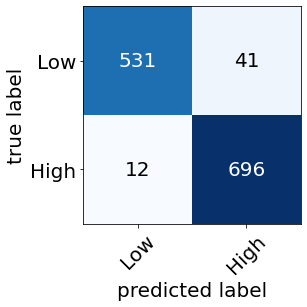

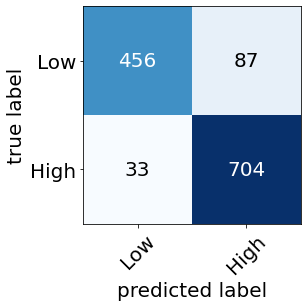

In [13]:
#===============================
# EDA results
#===============================

df = pd.read_csv(fname_eda)
val_true = df.iloc[:,6]
val_prdt = df.iloc[:,7]
aro_true = df.iloc[:,8]
aro_prdt = df.iloc[:,9]

#============================================
# Valence Classification Report
#============================================
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


val_y_true = val_true #Acutal class labels

val_y_pred = val_prdt #Predicted Class labels

cm = confusion_matrix(val_y_true, val_y_pred) # Confusion Matrix

target_names = ['Low','High'] # Class names

val_c_report = classification_report(val_y_true, val_y_pred, target_names=target_names) #Classification report

val_acc_score = accuracy_score(val_y_true, val_y_pred) #Balanced accuracy Score calculation

val_f1_scr = f1_score(val_y_true, val_y_pred)

print('resp belt Valence accuracy:')
print(val_acc_score)

print(' ')
print('resp belt Valence F1 Score')
print(val_f1_scr)

print(' ')

print('resp belt Valence Confiusion matric')
print(cm)

print(' ')

# print('Accuracy score', acc_score)

print('resp belt Valence Classification Report')
print(val_c_report)

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

class_names = target_names

## Plot Confusion matric Valence 
## ================================
plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=cm, show_absolute=True,
#                                 show_normed=True,
#                                 colorbar=True,
                                  class_names=class_names)
plt.figure(1)
# plt.show()

fname1 = str(time_stamp)+classifier+'valence resp belt.jpeg'

plt.savefig(fname1, bbox_inches='tight')


#============================================
# Arousal Classification Report
#============================================
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


aro_y_true = aro_true #Acutal class labels

aro_y_pred = aro_prdt #Predicted Class labels

cm = confusion_matrix(aro_y_true, aro_y_pred) # Confusion Matrix

target_names = ['Low','High'] # Class names

aro_c_report = classification_report(aro_y_true, aro_y_pred, target_names=target_names) #Classification report


aro_acc_score = accuracy_score(aro_y_true, aro_y_pred) #Balanced accuracy Score calculation

aro_f1_scr = f1_score(aro_y_true, aro_y_pred)

print('resp belt Arousal accuracy:')
print(aro_acc_score)

print(' ')
print('resp belt Arousal F1 Score')
print(aro_f1_scr)

print(' ')

print('resp belt Arousal Confiusion matric')
print(cm)

print(' ')

print('resp belt Arousal classification Report')
print(aro_c_report)

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

class_names = target_names

## Plot Confusion matric Valence 
## ================================
plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=cm, show_absolute=True,
#                                 show_normed=True,
#                                 colorbar=True,
                                  class_names=class_names)
plt.figure(2)
# plt.show()

fname2 = str(time_stamp)+classifier+'arousal resp belt.jpeg'

plt.savefig(fname2, bbox_inches='tight')